## PROJETO DE CLASSIFICAÇÃO DE IMAGENS DE RAIO-X

### OBJETIVO: IDENTIFICAR DOENÇA PNEUMONIA EM IMAGENS DE RAIO X

### IMAGENS CEDIDAS PELO https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

### FONTE ORIGINAL: https://data.mendeley.com/datasets/rscbjbr9sj/2

In [5]:
#!pip install tensorflow keras numpy pandas matplotlib scikit-learn
#!pip install opencv-python


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
#!pip install tqdm




2024-11-19 16:26:15.844388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732044375.860921   25865 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732044375.866420   25865 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 16:26:15.882109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
dataset_path = "dataset"


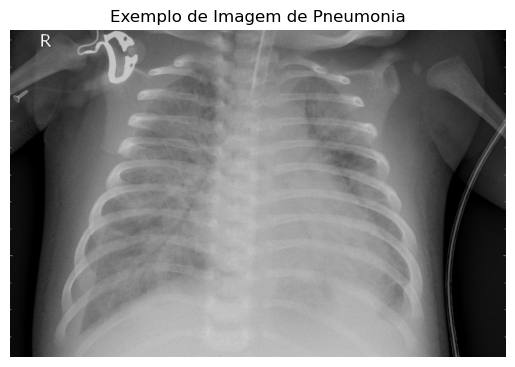

In [8]:
import matplotlib.pyplot as plt
import cv2

# Exemplo de leitura de imagem
sample_image = os.path.join(dataset_path, "train/pneumonia", os.listdir(os.path.join(dataset_path, "train/pneumonia"))[0])
img = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title("Exemplo de Imagem de Pneumonia")
plt.axis('off')
plt.show()


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalização
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # Separação Treino/Validação
)

# Gerar dados de treino e validação
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=(224, 224),  # Tamanho das imagens
    batch_size=32,
    class_mode='binary',  # Saída binária (0 ou 1)
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


In [11]:
# Gerador de dados para treinamento e validação
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar pixels
    rotation_range=10,  # Rotação
    width_shift_range=0.1,  # Deslocamento horizontal
    height_shift_range=0.1,  # Deslocamento vertical
    zoom_range=0.1,  # Zoom
    horizontal_flip=True,  # Espelhamento horizontal
    validation_split=0.2  # Separação treino/validação
)

# Geradores
train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [12]:
# Carregar o modelo ResNet50 sem as camadas superiores
base_model = ResNet50(
    weights='imagenet',
    include_top=False,  # Exclui a camada final pré-treinada
    input_shape=(224, 224, 3)
)

# Congelar as camadas do modelo base
base_model.trainable = False


2024-11-19 16:26:18.890201: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
# Adicionar camadas específicas para o diagnóstico de pneumonia
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduz dimensionalidade
    layers.Dense(128, activation='relu'),  # Camada densa intermediária
    layers.Dropout(0.5),  # Regularização
    layers.Dense(1, activation='sigmoid')  # Saída binária
])

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [14]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
# A SEGUIR A GERAÇÃO DOS ARQUIVOS PARQUET para treinar o modelo no spark - MUITO PESADO DESATIVEI A CELULA PARA NAO TRAVAR O NOTEBOOK

import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf

from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Caminho do dataset
dataset_path = "dataset"

# Função para processar imagens
def process_images(image_dir, label, img_size=(224, 224)):
    data = []
    for img_name in tqdm(os.listdir(image_dir), desc=f"Processing {label}"):
        img_path = os.path.join(image_dir, img_name)
        try:
            img = cv2.imread(img_path)  # Ler imagem
            img = cv2.resize(img, img_size)  # Redimensionar
            img = img / 255.0  # Normalizar
            data.append((img, label))  # Adicionar imagem e rótulo
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return data

# Processar as imagens das classes
pneumonia_dir = os.path.join(dataset_path, "train/pneumonia")
normal_dir = os.path.join(dataset_path, "train/normal")

pneumonia_data = process_images(pneumonia_dir, label=1)
normal_data = process_images(normal_dir, label=0)

# Combinar e embaralhar
all_data = pneumonia_data + normal_data
np.random.shuffle(all_data)

# Separar imagens e rótulos
images, labels = zip(*all_data)

# Dividir em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Criar DataFrame para salvar em Parquet
def create_dataframe(images, labels):
    flat_images = [img.flatten() for img in images]  # Achatar para salvar
    return pd.DataFrame(flat_images, columns=[f"pixel_{i}" for i in range(flat_images[0].size)]).assign(label=labels)

train_df = create_dataframe(X_train, y_train)
val_df = create_dataframe(X_val, y_val)
test_df = create_dataframe(X_test, y_test)

# Salvar os datasets em formato Parquet
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

train_df.to_parquet(os.path.join(output_dir, "train.parquet"), index=False)
val_df.to_parquet(os.path.join(output_dir, "val.parquet"), index=False)
test_df.to_parquet(os.path.join(output_dir, "test.parquet"), index=False)

print(f"Dados processados salvos em {output_dir}")


In [17]:
# NOVO CODIGO PARA GERAÇÃO DOS ARQUIVOS EM LOTE PARA NAO TRAVAR O COMPUTADOR - codigo abaixo gerou um unico arquivo

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import pickle

# Diretório base do dataset
base_dir = './dataset'

# Função para processar as imagens e salvar os dados como DataFrame
def processar_imagens(base_dir):
    # Estruturas para armazenar os dados
    dados = []

    # Loop pelas pastas principais (train, test, val)
    for subset in ['train', 'test', 'val']:
        subset_dir = os.path.join(base_dir, subset)
        print(f"Processando subset: {subset}")

        # Classes (subpastas "normal" e "pneumonia")
        for classe in os.listdir(subset_dir):
            classe_dir = os.path.join(subset_dir, classe)

            # Ignorar se não for um diretório
            if not os.path.isdir(classe_dir):
                continue

            # Processar cada imagem na subpasta
            for imagem_nome in tqdm(os.listdir(classe_dir), desc=f"Processando {classe}"):
                imagem_caminho = os.path.join(classe_dir, imagem_nome)

                try:
                    # Abrir e redimensionar a imagem
                    with Image.open(imagem_caminho) as img:
                        img = img.resize((128, 128))  # Redimensionar para 128x128
                        img_array = np.array(img)  # Converter para array

                    # Normalizar os valores da imagem
                    img_array = img_array / 255.0

                    # Serializar o array da imagem
                    img_serializada = pickle.dumps(img_array)

                    # Adicionar os dados ao DataFrame
                    dados.append({
                        'subset': subset,
                        'classe': classe,
                        'imagem': img_serializada  # Armazenar a imagem serializada
                    })
                except Exception as e:
                    print(f"Erro ao processar imagem {imagem_caminho}: {e}")

    # Converter os dados em DataFrame
    df = pd.DataFrame(dados)
    return df

# Processar as imagens e salvar como arquivo Parquet
print("Iniciando processamento das imagens...")
df_imagens = processar_imagens(base_dir)

# Salvar o DataFrame em formato Parquet
parquet_path = os.path.join(base_dir, 'imagens_processadas.parquet')
df_imagens.to_parquet(parquet_path, index=False)
print(f"Processamento concluído. Arquivo salvo em: {parquet_path}")


In [19]:
# AGORA VAMOS GERAR MULTIPLOS ARQUIVOS DE LOTE PARA PROCESSAR NO SPARK

import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

def processar_e_salvar_lotes(base_dir, output_dir, lote_tamanho=500):
    os.makedirs(output_dir, exist_ok=True)

    subsets = ['train', 'test', 'val']
    total_imagens = 0

    for subset in subsets:
        subset_dir = os.path.join(base_dir, subset)
        classes = os.listdir(subset_dir)

        for classe in classes:
            classe_dir = os.path.join(subset_dir, classe)
            imagens = os.listdir(classe_dir)

            print(f"Processando subset: {subset}, classe: {classe}, total: {len(imagens)} imagens")
            dados = []
            lote_atual = 1

            for idx, imagem_nome in enumerate(tqdm(imagens)):
                imagem_caminho = os.path.join(classe_dir, imagem_nome)

                try:
                    imagem = cv2.imread(imagem_caminho, cv2.IMREAD_GRAYSCALE)
                    imagem = cv2.resize(imagem, (224, 224))
                    imagem_serializada = np.array(imagem).tobytes()

                    dados.append({
                        'subset': subset,
                        'classe': classe,
                        'imagem': imagem_serializada
                    })

                    if len(dados) == lote_tamanho:
                        lote_path = os.path.join(output_dir, f'{subset}_{classe}_lote{lote_atual}.parquet')
                        pd.DataFrame(dados).to_parquet(lote_path, index=False)
                        print(f"Lote salvo: {lote_path}")
                        lote_atual += 1
                        dados = []

                except Exception as e:
                    print(f"Erro ao processar imagem {imagem_caminho}: {e}")

            if dados:
                lote_path = os.path.join(output_dir, f'{subset}_{classe}_lote{lote_atual}.parquet')
                pd.DataFrame(dados).to_parquet(lote_path, index=False)
                print(f"Lote final salvo: {lote_path}")

            total_imagens += len(imagens)

    print(f"Processamento concluído. Total de imagens processadas: {total_imagens}")

# Diretório base do dataset
base_dir = './dataset'
# Diretório de saída para arquivos Parquet
output_dir = './dataset/parquet_lotes'
# Processar e salvar as imagens em lotes menores
processar_e_salvar_lotes(base_dir, output_dir)


In [21]:
# carregar o arquivo parquet para CERTIFICAR QUE ESTA TUDO OK

In [22]:
import pandas as pd

# Carregar o arquivo Parquet
parquet_path = './dataset/imagens_processadas.parquet'
df = pd.read_parquet(parquet_path)

# Verificar as primeiras linhas
print(df.head())


  subset  classe                                             imagem
0  train  normal  b'\x80\x04\x95\x83\x00\x00\x00\x00\x00\x00\x00...
1  train  normal  b'\x80\x04\x95\x83\x00\x00\x00\x00\x00\x00\x00...
2  train  normal  b'\x80\x04\x95\x83\x00\x00\x00\x00\x00\x00\x00...
3  train  normal  b'\x80\x04\x95\x83\x00\x00\x00\x00\x00\x00\x00...
4  train  normal  b'\x80\x04\x95\x83\x00\x00\x00\x00\x00\x00\x00...


In [23]:
# a seguir o treinamento PRIMEIRO TESTE

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Ajuste conforme necessário
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


#avalar matris de Confusão
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Previsões no conjunto de validação
val_predictions = model.predict(val_generator)
val_predictions_classes = np.round(val_predictions).astype(int).flatten()

# Matrizes de avaliação
print(confusion_matrix(val_generator.classes, val_predictions_classes))
print(classification_report(val_generator.classes, val_predictions_classes))


In [26]:
# vou fazer ajuste e balanceamento entre classes

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Classe binária
    subset='training'
)


datagen = ImageDataGenerator(
    rescale=1./255,  # Normalização para [0, 1]
    validation_split=0.2
)


x, y = train_generator.__next__()
print("Shape das imagens:", x.shape)  # Deve ser (batch_size, 224, 224, 3)
print("Shape dos rótulos:", y.shape)  # Deve ser (batch_size,)


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Para saída binária
])


In [31]:
# balancear as classes

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular pesos das classes
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)

# Converter os pesos para um dicionário
class_weights = dict(enumerate(class_weights))
print("Pesos das classes:", class_weights)


A SEGUIR VOU USAR ALGORITIMO OTIMIZADO PELO 4o

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
from PIL import Image
import tensorflow as tf

# Caminhos para as pastas do dataset
base_dataset_path = "dataset"
train_path = os.path.join(base_dataset_path, "train")
val_path = os.path.join(base_dataset_path, "val")
test_path = os.path.join(base_dataset_path, "test")

# Função para validar imagens
def validar_imagens(diretorio):
    for root, _, files in os.walk(diretorio):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verifica a integridade da imagem
            except (IOError, SyntaxError, UnidentifiedImageError):
                print(f"Removendo arquivo inválido: {file_path}")
                os.remove(file_path)

# Validar imagens em todas as pastas
validar_imagens(train_path)
validar_imagens(val_path)
validar_imagens(test_path)

# Pré-processamento e augmentação
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

# Geradores de dados
train_generator_raw = datagen_train.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator_raw = datagen_val_test.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator_raw = datagen_val_test.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Ajustar geradores para garantir o formato correto
def ajustar_formato(generator):
    while True:
        data, labels = next(generator)  # Use a função `next()` aqui
        data = data.astype(np.float32)  # Garantir que os dados sejam float32
        yield data, labels

train_generator = ajustar_formato(train_generator_raw)
val_generator = ajustar_formato(val_generator_raw)
test_generator = ajustar_formato(test_generator_raw)

# Pesos das classes para balanceamento
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_generator_raw.classes),  # Usar gerador original
    y=train_generator_raw.classes
)
class_weights = dict(enumerate(class_weights))

# Criar uma função de perda ponderada
def weighted_binary_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Converter todos os tensores para float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        weights = tf.where(tf.equal(y_true, 1), class_weights[1], class_weights[0])
        weights = tf.cast(weights, tf.float32)  # Converter weights para float32
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return bce * weights
    return loss


# Modelo pré-treinado com ajuste fino
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True  # Descongelar camadas superiores para fine-tuning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compilação do modelo com perda ponderada
model.compile(
    optimizer='adam',
    loss=weighted_binary_crossentropy(class_weights),
    metrics=['accuracy']
)

# Treinamento do modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=len(train_generator_raw),
    validation_steps=len(val_generator_raw),
    verbose=1
)

# Avaliação do modelo
test_predictions = model.predict(test_generator)
test_predictions_classes = (test_predictions > 0.5).astype(int).flatten()

print("\nMatriz de Confusão e Relatório de Classificação:")
print(classification_report(test_generator_raw.classes, test_predictions_classes))
print("AUC-ROC Score:", roc_auc_score(test_generator_raw.classes, test_predictions))

# Salvando o modelo treinado
model.save("modelo_pneumonia_resnet50_final.h5")
print("\nModelo salvo como 'modelo_pneumonia_resnet50_final.h5'")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1495s 9s/step - accuracy: 0.8827 - loss: 0.3064 - val_accuracy: 0.5000 - val_loss: 345.9792
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1468s 9s/step - accuracy: 0.9478 - loss: 0.1494 - val_accuracy: 0.5000 - val_loss: 97.9088
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1457s 9s/step - accuracy: 0.9489 - loss: 0.1250 - val_accuracy: 0.5000 - val_loss: 11.7540
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1471s 9s/step - accuracy: 0.9568 - loss: 0.1204 - val_accuracy: 0.5000 - val_loss: 113.1920
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1469s 9s/step - accuracy: 0.9564 - loss: 0.1184 - val_accuracy: 0.5000 - val_loss: 11.1574
  28950/Unknown 50848s 2s/step

In [ ]:
# TESTE DE TREINAMENTOS COM ALGUNS AJUSTES

import os
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
from PIL import Image
import tensorflow as tf

# Caminhos para as pastas do dataset
base_dataset_path = "dataset"
train_path = os.path.join(base_dataset_path, "train")
val_path = os.path.join(base_dataset_path, "val")
test_path = os.path.join(base_dataset_path, "test")

# Função para validar imagens
def validar_imagens(diretorio):
    for root, _, files in os.walk(diretorio):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError):
                print(f"Removendo arquivo inválido: {file_path}")
                os.remove(file_path)

# Validar imagens
validar_imagens(train_path)
validar_imagens(val_path)
validar_imagens(test_path)

# Pré-processamento e augmentação
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

# Geradores de dados
train_generator = datagen_train.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen_val_test.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen_val_test.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Pesos das classes
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Modelo com ajuste fino
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Congelar camadas base para treinamento inicial

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Reduzindo overfitting
    layers.Dense(1, activation='sigmoid')
])

# Compilação do modelo
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Taxa de aprendizado ajustada
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Treinamento inicial
initial_epochs = 5
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=initial_epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights,
    verbose=1
)

# Fine-tuning
base_model.trainable = True  # Descongelar camadas para ajuste fino
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),  # Taxa de aprendizado menor para fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights,
    verbose=1
)

# Avaliação do modelo
test_predictions = model.predict(test_generator)
test_predictions_classes = (test_predictions > 0.5).astype(int).flatten()

print("\nRelatório de Classificação:")
print(classification_report(test_generator.classes, test_predictions_classes))
print("AUC-ROC Score:", roc_auc_score(test_generator.classes, test_predictions))

# Salvando o modelo
model.save("modelo_pneumonia_resnet50_otimizado.h5")
print("\nModelo salvo como 'modelo_pneumonia_resnet50_otimizado.h5'")
